<a href="https://colab.research.google.com/github/AbdullahHemada/Vision_project/blob/main/UCF101_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
pevogam_ucf101_path = kagglehub.dataset_download('pevogam/ucf101')

print('Data source import complete.')


# Import packages

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import time

import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD,Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

2025-12-06 21:22:04.726116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765056124.747326   35712 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765056124.753775   35712 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Hyperparameter

In [ ]:
# # Parameters
IMG_SIZE = (128, 128)
SEQUENCE_LENGTH = 20
BATCH_SIZE = 2
EPOCHS = 60
NUM_CLASSES = 5
Selected_classes = ['ApplyEyeMakeup', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching']

# Import Label File

In [ ]:
# Load label data
label_data = pd.read_csv("/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
print(label_data.head())


# Total Number of video folders for classification
print(len(label_data))
print(label_data['index'],label_data['labels'])

   index          labels
0      1  ApplyEyeMakeup
1      2   ApplyLipstick
2      3         Archery
3      4    BabyCrawling
4      5     BalanceBeam
101
0        1
1        2
2        3
3        4
4        5
      ... 
96      97
97      98
98      99
99     100
100    101
Name: index, Length: 101, dtype: int64 0         ApplyEyeMakeup
1          ApplyLipstick
2                Archery
3           BabyCrawling
4            BalanceBeam
             ...        
96     VolleyballSpiking
97        WalkingWithDog
98           WallPushups
99        WritingOnBoard
100                 YoYo
Name: labels, Length: 101, dtype: object


In [ ]:
# Filter label_data to only selected classes
label_data_filtered = label_data[label_data['labels'].isin(Selected_classes)]

# Create new class → index
class_to_index = {cls: i for i, cls in enumerate(Selected_classes)}

print("Filtered classes:", class_to_index)

Filtered classes: {'ApplyEyeMakeup': 0, 'Archery': 1, 'BabyCrawling': 2, 'BalanceBeam': 3, 'BandMarching': 4}


# import and read train01 and test01

1) Load train list & keep only selected classes

In [ ]:
#read train01.txt file
UCF101_path='/kaggle/input/ucf101/UCF101/UCF-101'
train01_path='/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/trainlist01.txt'
test01_path='/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/testlist01.txt'


# Load filtered train lists
def load_train_list_filtered(train01_path, selected_classes):
    videos = []
    labels = []

    with open(train01_path, 'r') as file:
        for line in file:
            video_file, label_num = line.strip().split()
            class_name = video_file.split('/')[0]

            # only keep selected classes
            if class_name in selected_classes:
                videos.append(video_file)
                labels.append(selected_classes.index(class_name))

    return videos, labels


# Load filtered  test lists
def load_test_list_filtered(test01_path, selected_classes):
    videos = []

    with open(test01_path, 'r') as file:
        for line in file:
            video_file = line.strip()
            class_name = video_file.split('/')[0]

            if class_name in selected_classes:
                videos.append(video_file)

    return videos


LOAD full path  FOR TRAINING AND TESTING

In [ ]:
# Load filtered train and test lists
train_videos, train_labels = load_train_list_filtered(train01_path, Selected_classes)
test_videos = load_test_list_filtered(test01_path, Selected_classes)



train_full_path=[]
for video in train_videos:
    train_full_path.append(os.path.join(UCF101_path, video))


test_full_path=[]
for video in test_videos:
    test_full_path.append(os.path.join(UCF101_path, video))

# print(train_full_path)
# print(test_full_path)


# Data Preperation

**get video fram size**

In [ ]:
# Print video frame sizes ONLY for selected classes
print("Reading video sizes for selected classes...\n")

for cls in Selected_classes:
    class_folder = os.path.join(UCF101_path, cls)
    for file in os.listdir(class_folder):
        if file.endswith(".avi"):
            video_path = os.path.join(class_folder, file)
            cap = cv2.VideoCapture(video_path)
            w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

            print(f"{cls}/{file}: {w}x{h}")

            cap.release()


Reading video sizes for selected classes...

ApplyEyeMakeup/v_ApplyEyeMakeup_g19_c01.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g25_c05.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g13_c02.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g25_c01.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g12_c02.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g21_c05.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g25_c03.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g20_c02.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c07.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g22_c01.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g05_c07.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g24_c03.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g20_c04.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c04.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g23_c05.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g05_c02.avi: 320x240
A

# ploting each category and its number


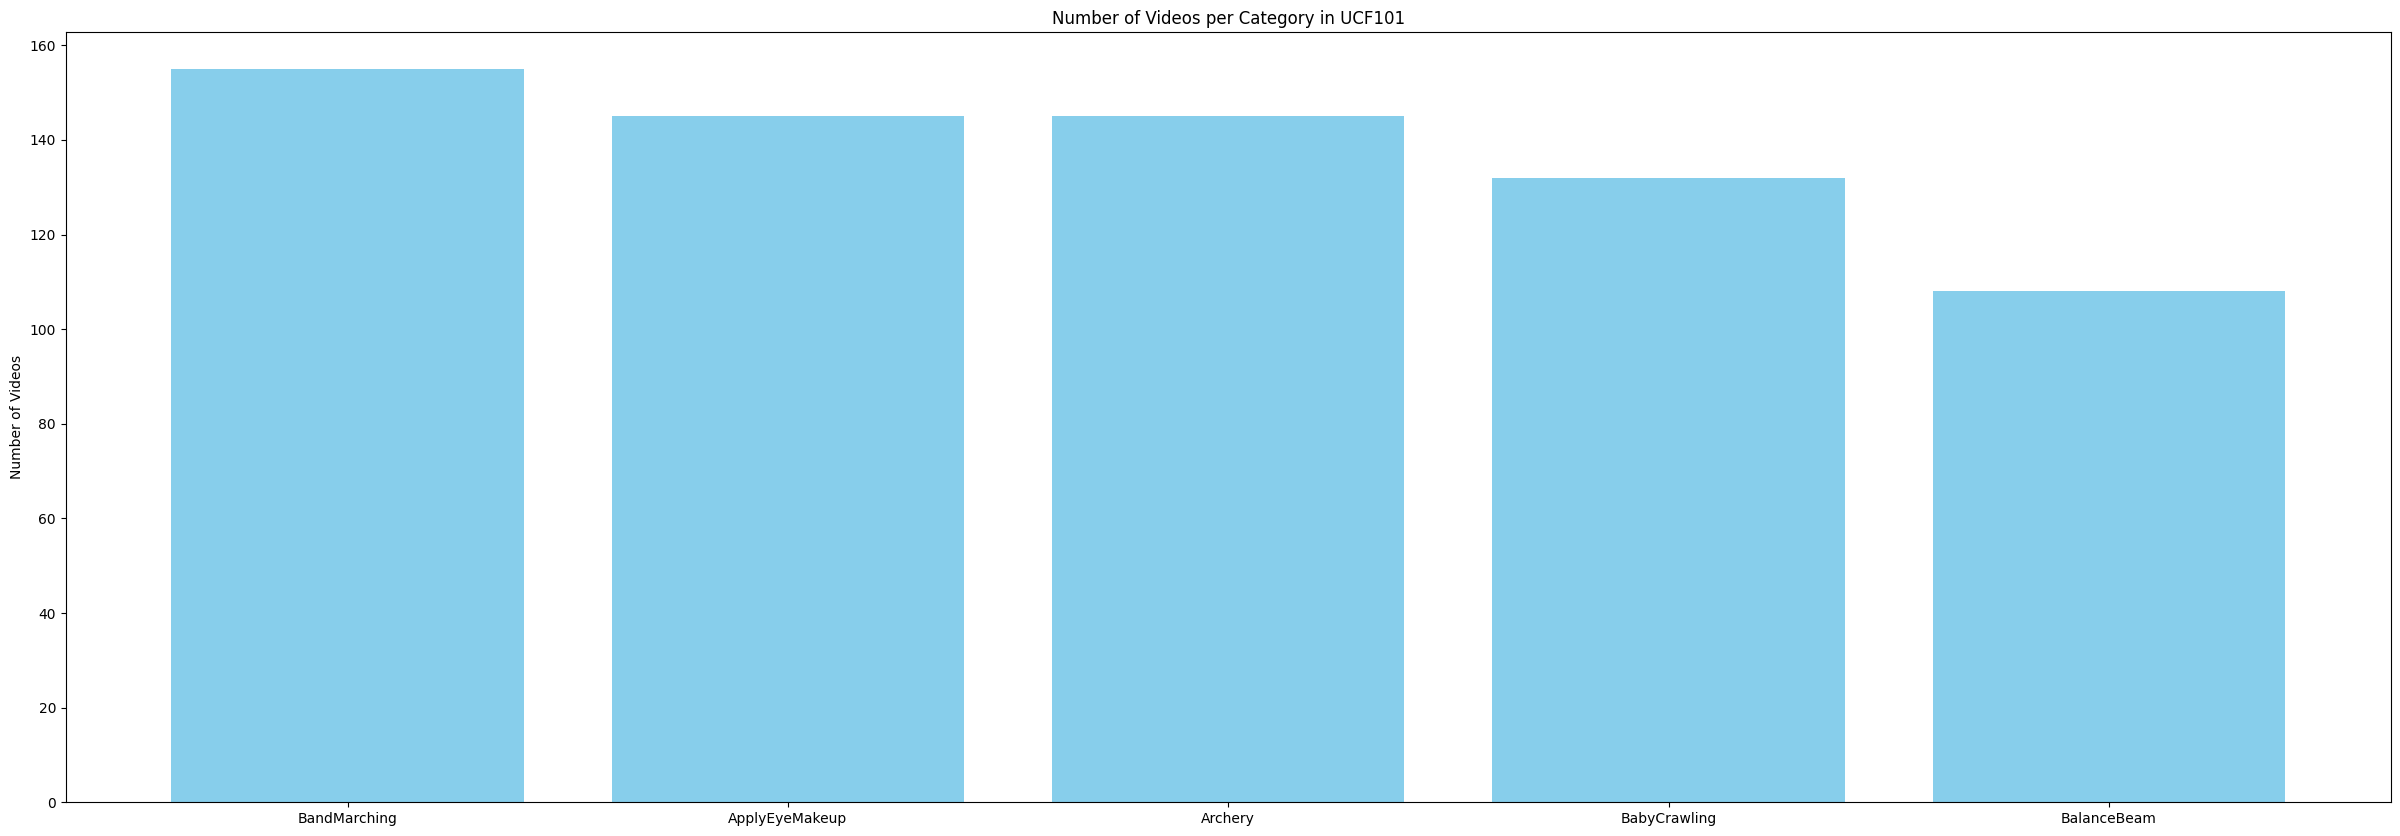

In [ ]:
# ploting each category and its number


# Count videos in each category
video_counts = {}
for category in Selected_classes:
    category_path = os.path.join(UCF101_path, category)
    videos = [f for f in os.listdir(category_path) if f.endswith(".avi")]
    video_counts[category] = len(videos)

# Sort categories by number of videos (descending)
sorted_counts = dict(sorted(video_counts.items(), key=lambda item: item[1], reverse=True))

# Plot bar chart
plt.figure(figsize=(30, 10))
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')
plt.ylabel("Number of Videos")
plt.title("Number of Videos per Category in UCF101")
plt.show()


# Function for Feature Extraction


In [ ]:
def extract_frames(video_path, sequence_length=SEQUENCE_LENGTH, img_size=IMG_SIZE):
    width, height = img_size
    frames_list = []

    video_reader = cv2.VideoCapture(video_path)
    frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    if frame_count <= 0:
        return [np.zeros((height, width, 3), dtype=np.float32)
                for _ in range(sequence_length)]

    # uniform frame sampling
    if frame_count < sequence_length:
        indices = np.linspace(0, frame_count - 1, sequence_length).astype(int)
    else:
        indices = np.linspace(0, frame_count - 1, sequence_length).astype(int)

    for idx in indices:
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = video_reader.read()

        if not ret:
            frame = np.zeros((height, width, 3), dtype=np.float32)
        else:
            frame = cv2.resize(frame, (width, height)).astype("float32") / 255.0

        frames_list.append(frame)

    video_reader.release()
    return np.array(frames_list)



# Augmentation Function

In [ ]:
# def augment_frames(frames):
#     aug_frames = []

#     for frame in frames:

#         f = frame.copy()

#         # Random horizontal flip
#         if random.random() < 0.5:
#             f = cv2.flip(f, 1)

#         # Random brightness change
#         if random.random() < 0.3:
#             factor = 0.8 + random.random() * 0.4
#             f = np.clip(f * factor, 0, 1)

#         # Color jitter
#         if random.random() < 0.3:
#             shift = random.uniform(-0.1, 0.1)
#             f = np.clip(f + shift, 0, 1)

#         # Random noise
#         if random.random() < 0.2:
#             noise = np.random.normal(0, 0.03, f.shape)
#             f = np.clip(f + noise, 0, 1)

#         aug_frames.append(f)

#     return np.array(aug_frames)


## Load selected train data from train01.txt

In [ ]:
def load_train_videos(video_paths, labels):
    X = []
    y = []

    for i, video_path in enumerate(tqdm(video_paths, desc="Loading TRAIN videos")):
        frames = extract_frames(video_path)          # extract
        # frames = augment_frames(frames)              # augment
        X.append(frames)
        y.append(labels[i])

    return np.array(X), np.array(y)


# Example usage
x_all, y_all = load_train_videos(train_full_path, train_labels)

# Train-validation split
x_train_manual, x_val_manual, y_train_manual, y_val_manual = train_test_split(
    x_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)


Loading TRAIN videos: 100%|██████████| 491/491 [03:09<00:00,  2.59it/s]


In [ ]:
def load_test_videos(video_paths, class_to_index, sequence_length=SEQUENCE_LENGTH, img_size=IMG_SIZE):

    X_test = []
    y_test = []

    for video_path in tqdm(video_paths, desc="Loading test videos"):
        class_name = os.path.basename(os.path.dirname(video_path))
        if class_name not in class_to_index:
            continue  # skip classes not selected
        label = class_to_index[class_name]
        frames = extract_frames(video_path)
        X_test.append(frames)
        y_test.append(label)

    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return X_test, y_test

# Example usage
x_test, y_test = load_test_videos(test_full_path, class_to_index)


Loading test videos: 100%|██████████| 194/194 [00:54<00:00,  3.55it/s]


## The Proposal model: MobilnetV2 + LSTM

In [ ]:
# Build model
def build_model_mobilenet_lstm():
    inputs = Input(shape=(SEQUENCE_LENGTH, IMG_SIZE[0], IMG_SIZE[1], 3))

    base_cnn = MobileNetV2(
        include_top=False,
        weights="imagenet",
        pooling=None
    )
    base_cnn.trainable = False

    # Preprocess inside model
    x = TimeDistributed(Lambda(preprocess_input))(inputs)

    # Apply CNN on each frame
    x = TimeDistributed(base_cnn)(x)
    x = TimeDistributed(GlobalAveragePooling2D())(x)

    # Temporal modeling with LSTM
    x = LSTM(256, return_sequences=False)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.4)(x)

    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-4)


In [ ]:
# define dictionaries BEFORE training
histories = {}
times = {}

**➤ 1. Train with Adam**

In [ ]:
model_adam = build_model_mobilenet_lstm()

model_adam.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(0.001),
    metrics=["accuracy"]
)


start = time.time()

history = model_adam.fit(
    x_train_manual, y_train_manual,
    validation_data=(x_val_manual, y_val_manual),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
)
end = time.time()

# Save results
histories["Adam"] = history
times["Adam"] = end - start

/tmp/ipykernel_35712/825971120.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_cnn = MobileNetV2(


Epoch 1/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 118s 248ms/step - accuracy: 0.2189 - loss: 1.6762 - val_accuracy: 0.2121 - val_loss: 1.6022 - learning_rate: 0.0010
Epoch 2/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.2409 - loss: 1.6090 - val_accuracy: 0.2121 - val_loss: 1.6204 - learning_rate: 0.0010
Epoch 3/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.2457 - loss: 1.6121 - val_accuracy: 0.3636 - val_loss: 1.5426 - learning_rate: 0.0010
Epoch 4/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - accuracy: 0.3123 - loss: 1.5347 - val_accuracy: 0.3535 - val_loss: 1.4528 - learning_rate: 0.0010
Epoch 5/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - accuracy: 0.4154 - loss: 1.4060 - val_accuracy: 0.3535 - val_loss: 1.3660 - learning_rate: 0.0010
Epoch 6/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.4359 - loss: 1.3911 - val_accuracy: 0.4141 - val_loss: 1.2102 - learning_rate: 0.0010
Epoch 7/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - accuracy: 0.

In [ ]:
y_pred = np.argmax(model_adam.predict(x_test), axis=1)
test_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_acc)

7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step 
Test Accuracy: 0.7164948453608248


**➤ 2. Train with SGD**

In [ ]:
model_sgd = build_model_mobilenet_lstm()

model_sgd.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=SGD(learning_rate=0.001),
    metrics=['accuracy']
)
start = time.time()
history_sgd = model_sgd.fit(
  x_train_manual, y_train_manual,
    validation_data=(x_val_manual, y_val_manual),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
)

end = time.time()

# Save results
histories["SGD"] = history
times["SGD"] = end - start

/tmp/ipykernel_35712/825971120.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_cnn = MobileNetV2(


Epoch 1/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 120s 243ms/step - accuracy: 0.1620 - loss: 1.6331 - val_accuracy: 0.2121 - val_loss: 1.6011 - learning_rate: 0.0010
Epoch 2/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.2062 - loss: 1.6079 - val_accuracy: 0.3636 - val_loss: 1.5955 - learning_rate: 0.0010
Epoch 3/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.2289 - loss: 1.5976 - val_accuracy: 0.2323 - val_loss: 1.5898 - learning_rate: 0.0010
Epoch 4/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.2187 - loss: 1.6030 - val_accuracy: 0.2828 - val_loss: 1.5872 - learning_rate: 0.0010
Epoch 5/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.1892 - loss: 1.6090 - val_accuracy: 0.2323 - val_loss: 1.5857 - learning_rate: 0.0010
Epoch 6/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.2720 - loss: 1.5851 - val_accuracy: 0.3636 - val_loss: 1.5847 - learning_rate: 0.0010
Epoch 7/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.

**➤ 3. Train with Adagrad**


In [ ]:
model_ada = build_model_mobilenet_lstm()

model_ada.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adagrad(learning_rate=0.001),
    metrics=['accuracy']
)
start = time.time()

history_ada = model_ada.fit(
       x_train_manual, y_train_manual,
    validation_data=(x_val_manual, y_val_manual),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
)
end = time.time()

histories["Adagrad"] = history_ada
times["Adagrad"] = end - start

/tmp/ipykernel_35712/825971120.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_cnn = MobileNetV2(


Epoch 1/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 119s 263ms/step - accuracy: 0.2190 - loss: 1.6217 - val_accuracy: 0.2323 - val_loss: 1.5960 - learning_rate: 0.0010
Epoch 2/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.2371 - loss: 1.5959 - val_accuracy: 0.2323 - val_loss: 1.5901 - learning_rate: 0.0010
Epoch 3/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.2900 - loss: 1.5929 - val_accuracy: 0.3030 - val_loss: 1.5887 - learning_rate: 0.0010
Epoch 4/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.2649 - loss: 1.5975 - val_accuracy: 0.3232 - val_loss: 1.5840 - learning_rate: 0.0010
Epoch 5/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.2841 - loss: 1.5844 - val_accuracy: 0.3131 - val_loss: 1.5837 - learning_rate: 0.0010
Epoch 6/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.3187 - loss: 1.5878 - val_accuracy: 0.3030 - val_loss: 1.5801 - learning_rate: 0.0010
Epoch 7/60
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.

In [ ]:
for opt, t in times.items():
    print(f"{opt}: {t:.2f} seconds")


Adam: 1450.62 seconds
Adagrad: 1442.36 seconds
SGD: 1450.19 seconds


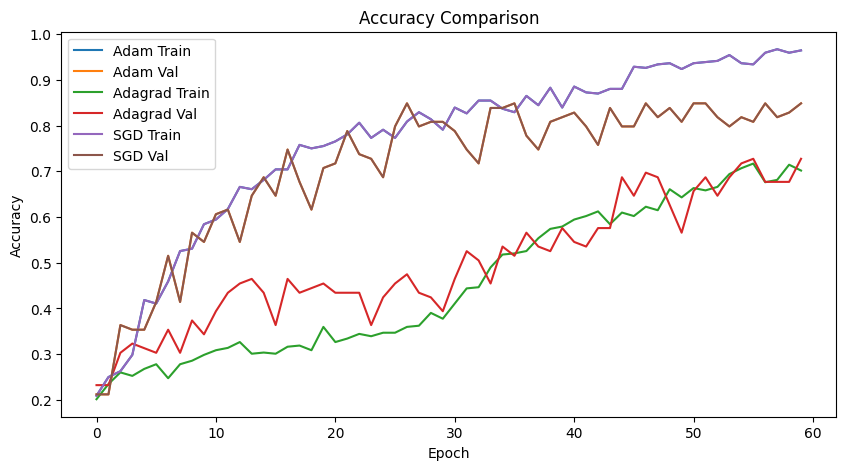

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

for name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{name} Train')
    plt.plot(history.history['val_accuracy'], label=f'{name} Val')

plt.title("Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


**Plot accuracy curves:**

**Plot loss curves:**

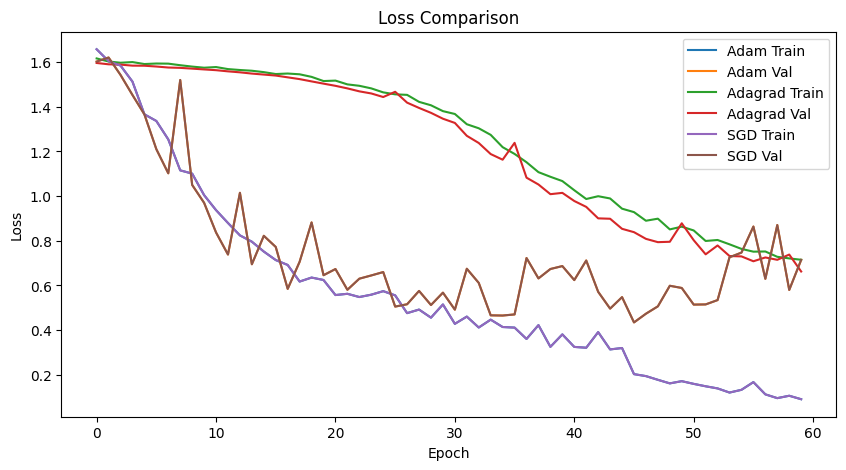

In [ ]:
plt.figure(figsize=(10,5))

for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} Train')
    plt.plot(history.history['val_loss'], label=f'{name} Val')

plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# One-hot encode test labels
# y_test_cat = to_categorical(y_test, NUM_CLASSES)

print("Adam Test Accuracy:", model_adam.evaluate(x_test, y_test))
print("SGD Test Accuracy:", model_sgd.evaluate(x_test, y_test))
print("Adagrad Test Accuracy:", model_ada.evaluate(x_test, y_test))



7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - accuracy: 0.6992 - loss: 1.2519
Adam Test Accuracy: [1.2155327796936035, 0.7164948582649231]
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.5432 - loss: 1.2546
SGD Test Accuracy: [1.282026767730713, 0.5051546096801758]
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.6854 - loss: 0.9706
Adagrad Test Accuracy: [0.9754776358604431, 0.6752577424049377]


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

test_accuracies = {}
test_predictions = {}

# -----------------------
# 🔵 1) ADAM
# -----------------------
y_pred_adam = model_adam.predict(x_test)
pred_class_adam = np.argmax(y_pred_adam, axis=1)

acc_adam = accuracy_score(y_test, pred_class_adam)
test_accuracies["Adam"] = acc_adam
test_predictions["Adam"] = pred_class_adam

print("Adam Test Accuracy:", acc_adam)


# -----------------------
# 🔴 2) SGD
# -----------------------
y_pred_sgd = model_sgd.predict(x_test)
pred_class_sgd = np.argmax(y_pred_sgd, axis=1)

acc_sgd = accuracy_score(y_test, pred_class_sgd)
test_accuracies["SGD"] = acc_sgd
test_predictions["SGD"] = pred_class_sgd

print("SGD Test Accuracy:", acc_sgd)


# -----------------------
# 🟢 3) ADAGRAD
# -----------------------
y_pred_ada = model_ada.predict(x_test)
pred_class_ada = np.argmax(y_pred_ada, axis=1)

acc_ada = accuracy_score(y_test, pred_class_ada)
test_accuracies["Adagrad"] = acc_ada
test_predictions["Adagrad"] = pred_class_ada

print("Adagrad Test Accuracy:", acc_ada)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step
Adam Test Accuracy: 0.7164948453608248
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step 
SGD Test Accuracy: 0.5051546391752577
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step 
Adagrad Test Accuracy: 0.6752577319587629


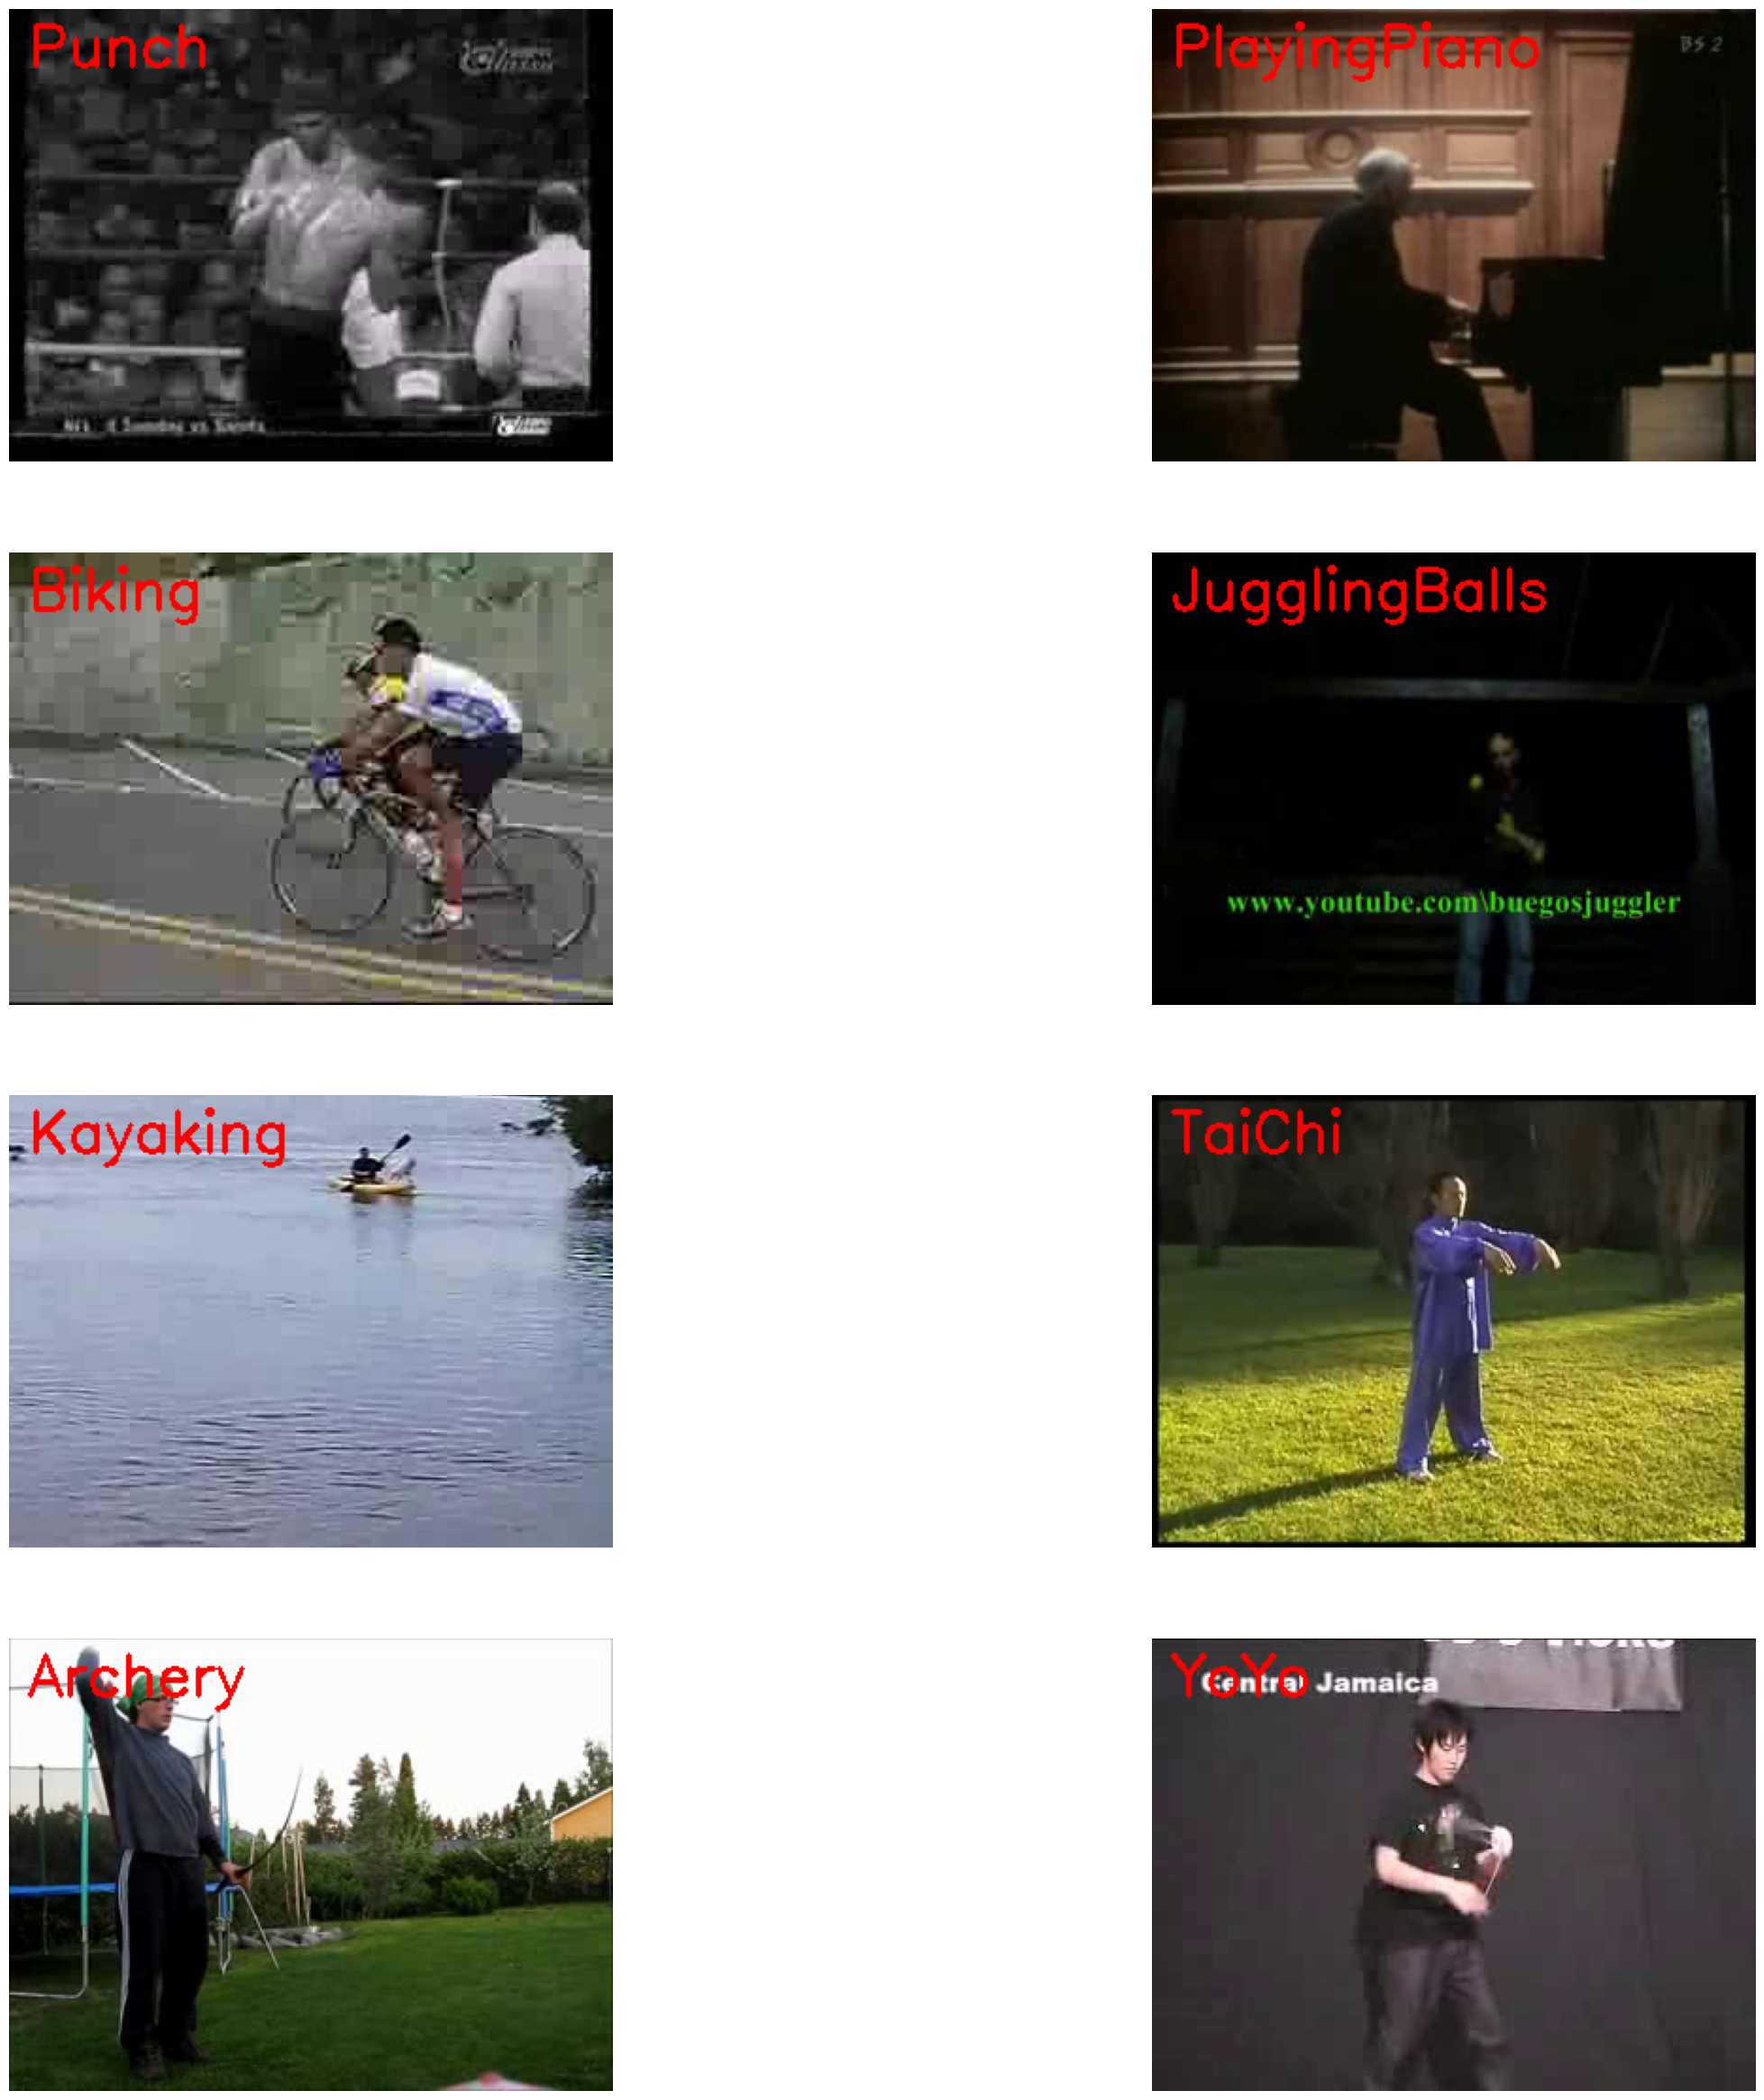

In [ ]:
import random
import os
import cv2

plt.figure(figsize=(30, 30))

all_classes_names = label_data.labels.values

random_classes = random.sample(list(all_classes_names), 8)

for i, class_name in enumerate(random_classes, 1):

    video_files = os.listdir(f'/kaggle/input/ucf101/UCF101/UCF-101/{class_name}')
    selected_video = random.choice(video_files)

    video_reader = cv2.VideoCapture(
        f'/kaggle/input/ucf101/UCF101/UCF-101/{class_name}/{selected_video}'
    )

    _, frame = video_reader.read()
    video_reader.release()

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.putText(frame, class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

    plt.subplot(4, 2, i)
    plt.imshow(frame)
    plt.axis("off")



====== OPTIMIZER COMPARISON TABLE ======
  Optimizer  Train Time (s)  Test Accuracy
0      Adam     1450.617064       0.716495
1       SGD     1450.192593       0.505155
2   Adagrad     1442.360710       0.675258


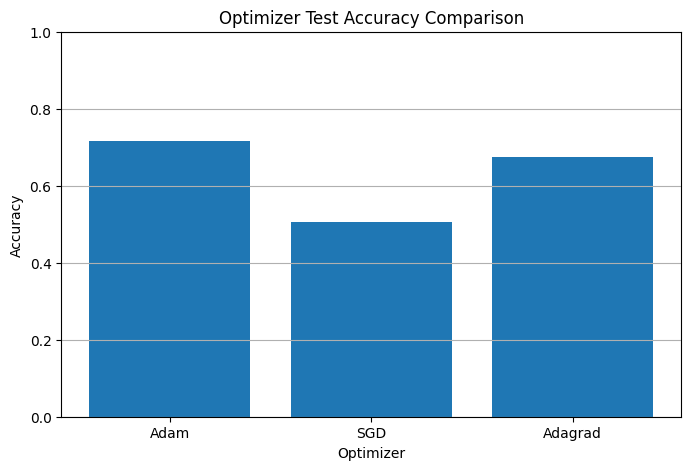

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step


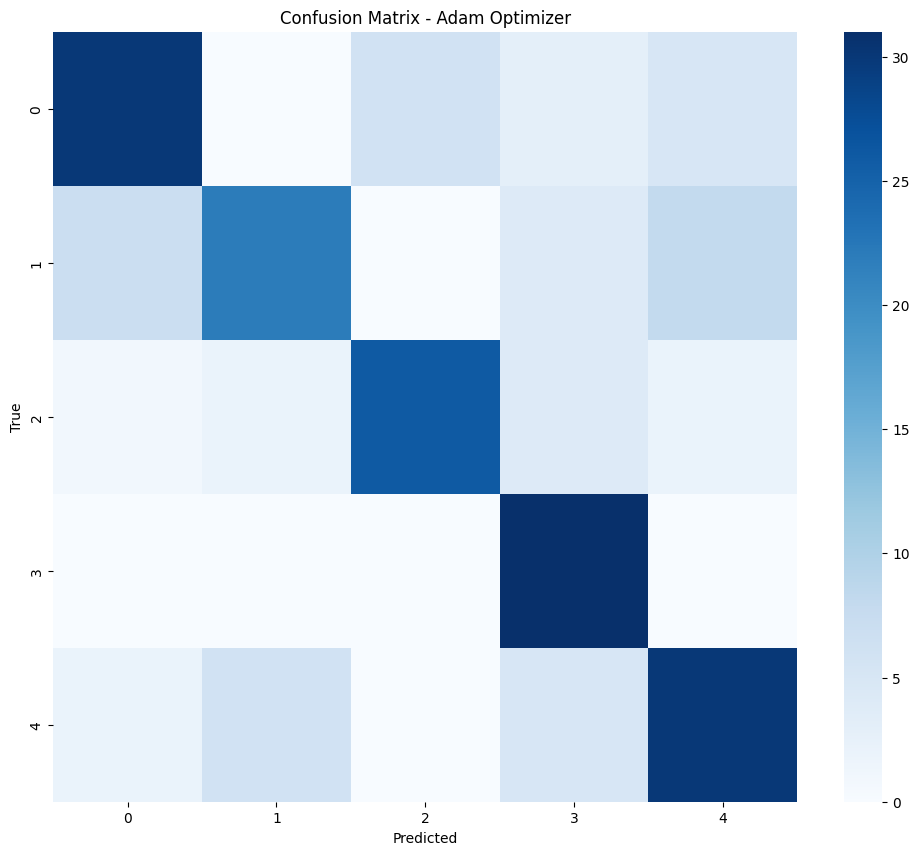

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step


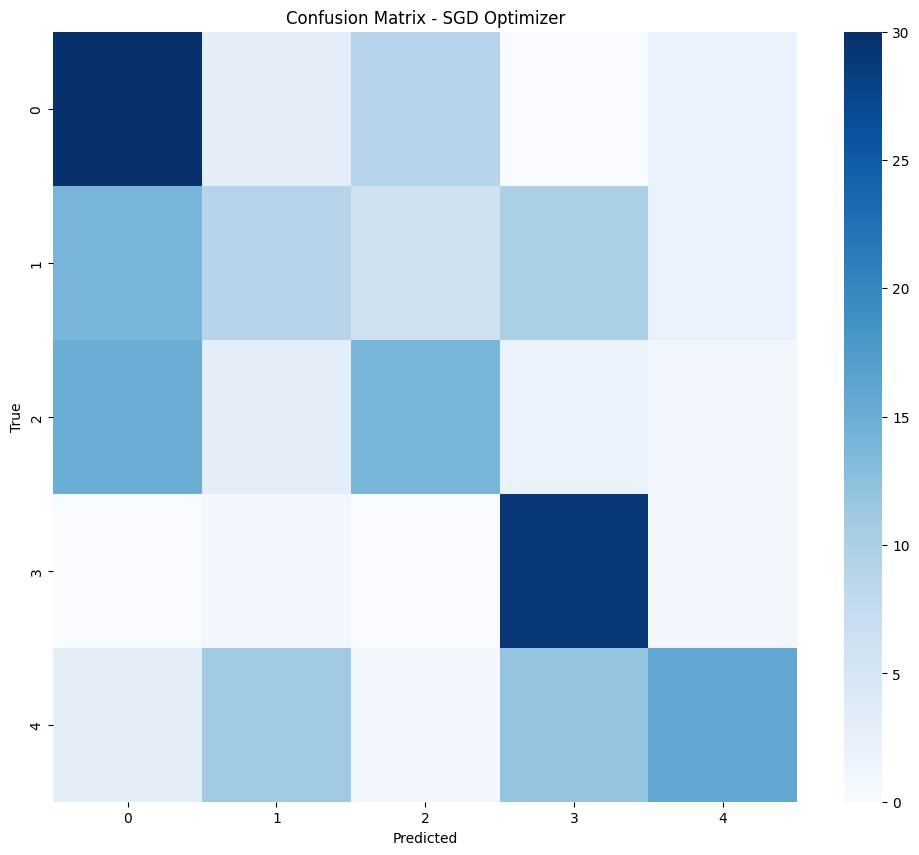

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step


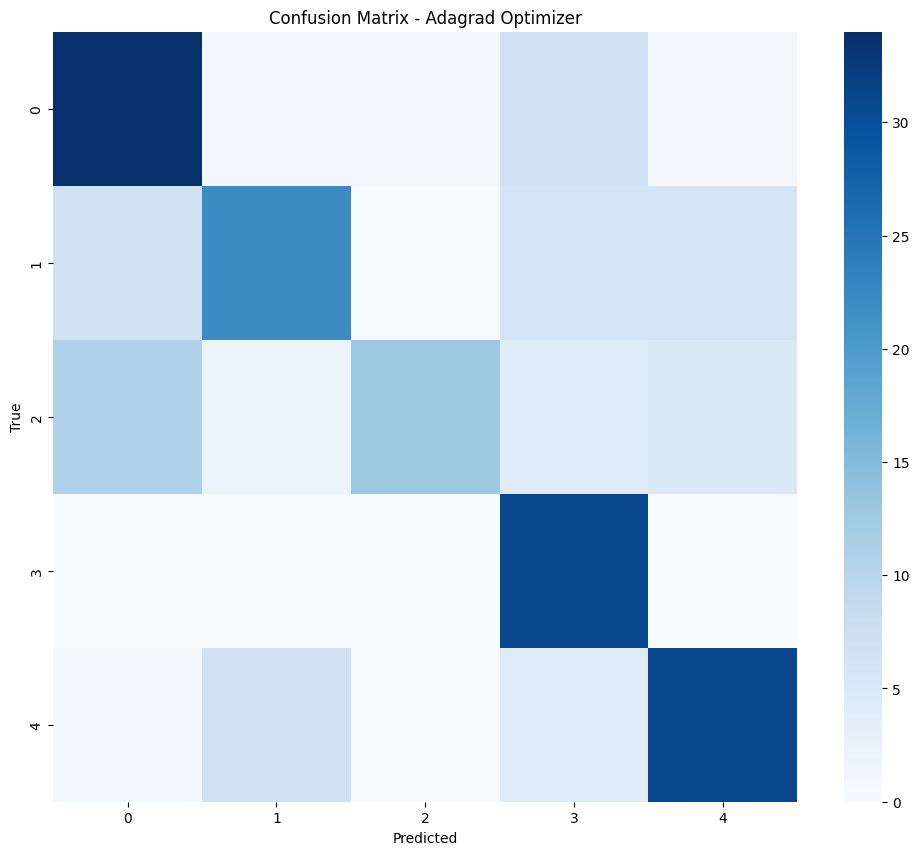

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# ============================
# 1) Compute Test Accuracies
# ============================

test_acc = {}

# Adam
loss_a, acc_a = model_adam.evaluate(x_test, y_test, verbose=0)
test_acc["Adam"] = acc_a

# SGD
loss_s, acc_s = model_sgd.evaluate(x_test, y_test, verbose=0)
test_acc["SGD"] = acc_s

# Adagrad
loss_g, acc_g = model_ada.evaluate(x_test, y_test, verbose=0)
test_acc["Adagrad"] = acc_g


# ============================
# 2) Print Comparison Table
# ============================

print("\n====== OPTIMIZER COMPARISON TABLE ======")
df_results = pd.DataFrame({
    "Optimizer": ["Adam", "SGD", "Adagrad"],
    "Train Time (s)": [times["Adam"], times["SGD"], times["Adagrad"]],
    "Test Accuracy": [test_acc["Adam"], test_acc["SGD"], test_acc["Adagrad"]],
})
print(df_results)


# ============================
# 3) Accuracy Bar Chart
# ============================

plt.figure(figsize=(8,5))
plt.bar(test_acc.keys(), test_acc.values())
plt.title("Optimizer Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Optimizer")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


# ============================
# 4) Confusion Matrices
# ============================

def plot_cm(model, y_true, title):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(12,10))
    sns.heatmap(cm, cmap="Blues", annot=False, fmt="d")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Adam Confusion Matrix
plot_cm(model_adam, y_test, "Confusion Matrix - Adam Optimizer")

# SGD Confusion Matrix
plot_cm(model_sgd, y_test, "Confusion Matrix - SGD Optimizer")

# Adagrad Confusion Matrix
plot_cm(model_ada, y_test, "Confusion Matrix - Adagrad Optimizer")


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

optimizers = {
    "Adam": model_adam,
    "SGD": model_sgd,
    "Adagrad": model_ada
}

# Class names (must match your label indices)
class_names = Selected_classes     # Example: ["angry","disgust","fear","happy","neutral","sad","surprise"]

# y_test is already integer labels (NO one-hot)
y_true = y_test   # <-- Correct!

for opt_name, model in optimizers.items():
    print("="*70)
    print(f"           Classification Report for {opt_name} Optimizer")
    print("="*70)

    # Predict
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Print report
    print(classification_report(
        y_true,
        y_pred_classes,
        target_names=class_names
    ))

    print("\n\n")


           Classification Report for Adam Optimizer
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step
                precision    recall  f1-score   support

ApplyEyeMakeup       0.75      0.68      0.71        44
       Archery       0.73      0.54      0.62        41
  BabyCrawling       0.81      0.74      0.78        35
   BalanceBeam       0.66      1.00      0.79        31
  BandMarching       0.67      0.70      0.68        43

      accuracy                           0.72       194
     macro avg       0.72      0.73      0.72       194
  weighted avg       0.72      0.72      0.71       194




           Classification Report for SGD Optimizer
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step
                precision    recall  f1-score   support

ApplyEyeMakeup       0.48      0.68      0.57        44
       Archery       0.33      0.22      0.26        41
  BabyCrawling       0.47      0.40      0.43        35
   BalanceBeam       0.55      0.94      0.69        31
  BandMarching       0.73   

In [ ]:
# Save the trained model Adam_optimizer
model_adam.save('Action_Recognition_model_Adam_optimizer.keras')
print("Model saved to Action Recognition_model_Adam_optimizer.keras")

# Save the trained model SGD_optimizer
model_sgd.save('Action_Recognition_model_SGD_optimizer.keras')
print("Model saved to Action Recognition_model_SGD_optimizer.keras")

# Save the trained model Adagrad_optimizer
model_ada.save('Action_Recognition_model_Adagrad_optimizer.keras')
print("Model saved to Action Recognition_model_Adagrad_optimizer.keras")

Model saved to Action Recognition_model_Adam_optimizer.keras
Model saved to Action Recognition_model_SGD_optimizer.keras
Model saved to Action Recognition_model_Adagrad_optimizer.keras
